# Common

In [239]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # !pip install tqdm
from tqdm import trange
import multiprocessing as mp
import shutil
import os

In [240]:
def bracket_row(row):    
    s = row['data']
    index = min(s.find('.'), s.find('('))
    data = row['data']
    row['data'] = data[0:index]
    row['bracket'] = data[index:]
    return row

In [137]:
def adjust(text,n=7):
    text = str(text)    
    return " " * (n - len(text)) + text

In [246]:
def bracket_to_ct(tag, data, bracket, deltaG, negative_deltaG=True):    
    deltaG = deltaG.replace('(','').replace(')','')
    deltaG = float(deltaG)
    if(deltaG > 0 and negative_deltaG ): # negetive?!
        deltaG = -1 * deltaG
    stack = []
    index = np.zeros((len(bracket)), dtype = int)
    values = np.zeros((len(bracket)), dtype = int)
    for i in range(len(bracket)):
        index[i] = i + 1
        if(bracket[i] == '.'):
            values[i] = 0
        elif(bracket[i] == '('):
            stack.append(i)
        elif(bracket[i] == ')'):
            if(len(stack) == 0 ):
                print('structure error!')
            values[stack[-1]] = i + 1
            values[i]  = stack[-1] + 1
            stack.pop()
        else:
            print('structure error!')
    if(len(stack) != 0 ):
        print('structure error!')
    # body    
    ct = f"{adjust(len(data),6)} dG ={adjust(deltaG,10)} {tag}\n"   
    for i in range(len(bracket)):
        ct += f"{adjust(index[i],6)} {data[i]} {adjust(i,6)} {adjust((i+2)%(len(data)+1),6)} {adjust(values[i],6)} {adjust(index[i],7)}\n"
    return ct

In [48]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [49]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [270]:
def reformat(path):
    return path.replace('(','_').replace(')','_').replace('.','').replace(':','_')

### rename tag of input genome to new tag id

# Download dataset

In [186]:
from Bio import Entrez
Entrez.email = "abolhasani.eliya@gmail.com"     
with Entrez.esearch(db='nucleotide', term="Arabidopsis thaliana") as handle:
    result = Entrez.read(handle)

print(result)
genome_ids = result['IdList']

for genome_id in genome_ids:
    print(genome_id)
    record = Entrez.efetch(db="nucleotide", id=genome_id, rettype="fasta", retmode="text")        
    with open(f'{genome_id}.fasta', 'w') as f:
        f.write(record.read())
    break

{'Count': '3344178', 'RetMax': '20', 'RetStart': '0', 'IdList': ['2112722214', '2112720223', '2112718526', '2112713974', '2112712776', '2112711465', '2112710136', '2112708929', '2112707731', '2112706611', '2112705454', '2112704446', '2112703491', '2112702625', '2112701442', '2112700588', '2112699487', '2112698892', '2112697886', '2112697471'], 'TranslationSet': [{'From': 'Arabidopsis thaliana', 'To': '"Arabidopsis thaliana"[Organism] OR Arabidopsis thaliana[All Fields]'}], 'TranslationStack': [{'Term': '"Arabidopsis thaliana"[Organism]', 'Field': 'Organism', 'Count': '2700195', 'Explode': 'Y'}, {'Term': 'Arabidopsis thaliana[All Fields]', 'Field': 'All Fields', 'Count': '3344178', 'Explode': 'N'}, 'OR', 'GROUP'], 'QueryTranslation': '"Arabidopsis thaliana"[Organism] OR Arabidopsis thaliana[All Fields]'}
2112722214


KeyboardInterrupt: 

In [68]:
from Bio import Entrez
Entrez.email = "abolhasani.eliya@gmail.com"     
record = Entrez.efetch(db="nucleotide", id="NC_054143.4", rettype="fasta", retmode="text")        
with open(f'data.fasta', 'w') as f:
    f.write(record.read())

In [259]:
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/439/995/GCA_000439995.3_AzaInd2.1/GCA_000439995.3_AzaInd2.1_genomic.fna.gz

--2021-10-24 19:04:50--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/439/995/GCA_000439995.3_AzaInd2.1/GCA_000439995.3_AzaInd2.1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.11, 2607:f220:41f:250::229, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85647577 (82M) [application/x-gzip]
Saving to: ‘GCA_000439995.3_AzaInd2.1_genomic.fna.gz’

GCA_000439995.3_Aza 100%[===================>]  81.68M  9.70MB/s    in 10s     

2021-10-24 19:05:01 (7.99 MB/s) - ‘GCA_000439995.3_AzaInd2.1_genomic.fna.gz’ saved [85647577/85647577]



In [263]:
!gzip -d ./GCA_000439995.3_AzaInd2.1_genomic.fna.gz

# Download data from Mirbase

In [112]:
base = "ftp://mirbase.org/pub/mirbase/CURRENT"
!wget {base}/aliases.txt.gz -P ./Data/          ; gzip -d ./Data/aliases.txt.gz 
!wget {base}/hairpin.fa.gz -P ./Data/           ; gzip -d ./Data/hairpin.fa.gz 
!wget {base}/hairpin_high_conf.fa.gz -P ./Data/ ; gzip -d ./Data/hairpin_high_conf.fa.gz 
!wget {base}/mature.fa.gz -P ./Data/            ; gzip -d ./Data/mature.fa.gz 
!wget {base}/mature_high_conf.fa.gz -P ./Data/  ; gzip -d ./Data/mature_high_conf.fa.gz
!wget {base}/miRNA.str.gz -P ./Data/            ; gzip -d ./Data/miRNA.str.gz 
!wget {base}/miRNA.xls.gz -P ./Data/            ; gzip -d ./Data/miRNA.xls.gz 
!wget {base}/organisms.txt.gz -P ./Data/        ; gzip -d ./Data/organisms.txt.gz

--2021-10-21 15:12:53--  ftp://mirbase.org/pub/mirbase/CURRENT/aliases.txt.gz
           => ‘./Data/aliases.txt.gz’
Resolving mirbase.org (mirbase.org)... 130.88.97.249
Connecting to mirbase.org (mirbase.org)|130.88.97.249|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/mirbase/CURRENT ... done.
==> SIZE aliases.txt.gz ... 480536
==> PASV ... done.    ==> RETR aliases.txt.gz ... done.
Length: 480536 (469K) (unauthoritative)

aliases.txt.gz      100%[===================>] 469.27K   415KB/s    in 1.1s    

2021-10-21 15:12:55 (415 KB/s) - ‘./Data/aliases.txt.gz’ saved [480536]

--2021-10-21 15:12:55--  ftp://mirbase.org/pub/mirbase/CURRENT/hairpin.fa.gz
           => ‘./Data/hairpin.fa.gz’
Resolving mirbase.org (mirbase.org)... 130.88.97.249
Connecting to mirbase.org (mirbase.org)|130.88.97.249|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I 

In [3]:
df = fasta_to_df('./Data/mature.fa')
#df = fasta_to_df('./Data/mature_high_conf.fa')
#df = fasta_to_df('./Data/hairpin_high_conf.fa')
df['organism'] = df['tag'].apply(lambda x: x[:3])
print(df.shape)
df.head(2)

(48885, 3)


,tag,data,organism
0,cel-let-7-5p MIMAT0000001 Caenorhabditis elega...,UGAGGUAGUAGGUUGUAUAGUU,cel
1,cel-let-7-3p MIMAT0015091 Caenorhabditis elega...,CUAUGCAAUUUUCUACCUUACC,cel


In [5]:
organism = pd.read_csv('./Data/organisms.txt',sep='\t')
organism.columns = [c.replace('#','') for c in organism.columns] # remove sharp from columns
print(organism.shape)
organism.head(2)

(285, 5)


,organism,division,name,tree,NCBI-taxid
0,aqu,AQU,Amphimedon queenslandica,Metazoa;Porifera;,400682
1,nve,NVE,Nematostella vectensis,Metazoa;Cnidaria;,45351


In [6]:
items = list(organism['tree'].unique())
items.sort(key=len)
items

['Viruses;',
 'Mycetozoa;',
 'Alveolata;',
 'Metazoa;Porifera;',
 'Metazoa;Cnidaria;',
 'Viridiplantae;Chlorophyta;',
 'Viridiplantae;Embryophyta;',
 'Viridiplantae;Coniferophyta;',
 'Viridiplantae;Magnoliophyta;',
 'Metazoa;Bilateria;Deuterostoma;',
 'Chromalveolata;Heterokontophyta;',
 'Metazoa;Bilateria;Ecdysozoa;Nematoda;',
 'Metazoa;Bilateria;Lophotrochozoa;Annelida;',
 'Metazoa;Bilateria;Lophotrochozoa;Nemertea;',
 'Metazoa;Bilateria;Lophotrochozoa;Mollusca;',
 'Viridiplantae;Magnoliophyta;monocotyledons;',
 'Metazoa;Bilateria;Deuterostoma;Hemichordata;',
 'Metazoa;Bilateria;Deuterostoma;Echinodermata;',
 'Metazoa;Bilateria;Lophotrochozoa;Brachiopoda;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Hexapoda;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Crustacea;',
 'Metazoa;Bilateria;Lophotrochozoa;Platyhelminthes;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Chelicerata;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Mandibulata;',
 'Viridiplantae;Magnoliophyta;eudicotyledons;Poaceae;',
 'M

In [7]:
selectedTree = organism[organism['tree'].apply(lambda x: "Viridiplantae;" in x)]
print(selectedTree.shape)
selectedTree.head(5)

(86, 5)


,organism,division,name,tree,NCBI-taxid
66,cre,CRE,Chlamydomonas reinhardtii,Viridiplantae;Chlorophyta;,3055
67,pta,PTA,Pinus taeda,Viridiplantae;Coniferophyta;,3352
68,ppt,PPT,Physcomitrella patens,Viridiplantae;Embryophyta;,3218
69,smo,SMO,Selaginella moellendorffii,Viridiplantae;Embryophyta;,88036
70,ath,ATH,Arabidopsis thaliana,Viridiplantae;Magnoliophyta;eudicotyledons;Bra...,3702


In [8]:
selected = df[df['organism'].isin(selectedTree['organism'])]
print(selected.shape)
selected.head()

(10414, 3)


,tag,data,organism
316,ath-miR156a-5p MIMAT0000166 Arabidopsis thalia...,UGACAGAAGAGAGUGAGCAC,ath
317,ath-miR156a-3p MIMAT0031865 Arabidopsis thalia...,GCUCACUGCUCUUUCUGUCAGA,ath
318,ath-miR156b-5p MIMAT0000167 Arabidopsis thalia...,UGACAGAAGAGAGUGAGCAC,ath
319,ath-miR156b-3p MIMAT0031866 Arabidopsis thalia...,UGCUCACCUCUCUUUCUGUCAGU,ath
320,ath-miR156c-5p MIMAT0000168 Arabidopsis thalia...,UGACAGAAGAGAGUGAGCAC,ath


In [9]:
df_to_fasta(selected,'./Temp/selected.fasta')

# Remove redundant

## cdhit-est

In [13]:
!cdhit/cd-hit-est -i ./Temp/selected.fasta  -o ./Temp/out.fasta \
    -c 1 -r 0 -G 1 -g 1 -b 30 -l 10 -aL 0 -AL 99999999 -aS 0 \
    -AS 99999999 -s 0 -S 0 

Program: CD-HIT, V4.8.1 (+OpenMP), Oct 23 2021, 21:45:39
Command: cdhit/cd-hit-est -i ./Temp/selected.fasta -o
         ./Temp/out.fasta -c 1 -r 0 -G 1 -g 1 -b 30 -l 10 -aL 0
         -AL 99999999 -aS 0 -AS 99999999 -s 0 -S 0

Started: Wed Oct 27 20:00:13 2021
                            Output                              
----------------------------------------------------------------
total seq: 10414
longest and shortest : 28 and 17
Total letters: 222978
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 1M
Buffer          : 1 X 12M = 12M
Table           : 1 X 16M = 16M
Miscellaneous   : 0M
Total           : 30M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 96149440

comparing sequences from          0  to      10414
..........    10000  finished       5817  clusters

    10414  finished       6028  clusters

Approximated maximum memory consumption: 31M
writing new database
w

## reformat

In [14]:
with open('./Temp/out.fasta.clstr','r') as file:
    text = file.read()
lines = [line for line in text.split('\n') if len(line) > 0]
cluster = []
seqid = []
last_cluster = ""
for l in lines:
    if(l[0]=='>'):        
        last_cluster = l.replace('>Cluster ',"C")
    else:        
        cluster.append(last_cluster)
        seqid.append(l.split(', >')[1].split('...')[0])                
seq2cluster = pd.DataFrame({'seqid': seqid,'cluster': cluster})
print(seq2cluster.shape)
seq2cluster.head(2)    

(10414, 2)


,seqid,cluster
0,cst-miR11332,C0
1,stu-miR7994b-5p,C1


In [15]:
df = fasta_to_df("./Temp/selected.fasta")
df['accession'] = df['tag'].apply(lambda x : x.split(' ')[0])
seq2cluster = pd.merge(df,seq2cluster,how="inner",left_on='accession',right_on="seqid")[['cluster','seqid','tag']]
print(seq2cluster.shape)
display(seq2cluster.head(2))
seq2cluster.to_csv('./Temp/seq2cluster.csv',index=False)

(10414, 3)


,cluster,seqid,tag
0,C5495,ath-miR156a-5p,ath-miR156a-5p MIMAT0000166 Arabidopsis thalia...
1,C1199,ath-miR156a-3p,ath-miR156a-3p MIMAT0031865 Arabidopsis thalia...


In [16]:
# todo: sorted first by cluster then by seqid
seq2cluster.sort_values("cluster").head(2)

,cluster,seqid,tag
9422,C0,cst-miR11332,cst-miR11332 MIMAT0044622 Cucumis sativus miR1...
7002,C1,stu-miR7994b-5p,stu-miR7994b-5p MIMAT0031188 Solanum tuberosum...


In [17]:
df = fasta_to_df("./Temp/out.fasta")
df['tag'] = df['tag'].apply(lambda x : x.split(' ')[0])
df = pd.merge(df,seq2cluster,how="inner",left_on='tag',right_on="seqid")[['cluster','data']]

lines = []
df.apply(lambda row: lines.append(f">{row['cluster']}\n{row['data']}\n"),axis=1)
print(df.shape)
with open('./Temp/selected_clustrerd.fasta','w') as file:
    file.write(''.join(lines))

(6028, 2)


# BlastN

!sudo apt-get install ncbi-blast+


In [18]:
!makeblastdb -in input_genome.fna \
             -dbtype nucl \
             -out ./Temp/blastn_database



Building a new DB, current time: 10/27/2021 20:01:13
New DB name:   /home/jupyter/plant_microRNA_prediction/Temp/blastn_database
New DB title:  input_genome.fna
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 126142 sequences in 9.91275 seconds.


In [5]:
header = "qseqid sseqid qstart qend sstart send qseq sseq evalue bitscore score length pident nident mismatch positive gapopen gaps ppos frames qframe sframe sstrand qcovs qcovhsp qlen slen"

In [29]:
blast_header = "6 " + header
!blastn -query ./Temp/selected_clustrerd.fasta \
        -out ./Temp/out_blastn \
        -num_threads {mp.cpu_count()} \
        -db ./Temp/blastn_database \
        -word_size 7 \
        -penalty -3 \
        -reward 2 \
        -gapopen 5 \
        -gapextend 2 \
        -outfmt {blast_header}

In [6]:
df = pd.read_csv('./Temp/out_blastn', sep='\t',header=None)
df.columns = header.replace("  "," ").split(" ")
print(df.shape)
df.head(2)

(326849, 27)


,qseqid,sseqid,qstart,qend,sstart,send,qseq,sseq,evalue,bitscore,...,gaps,ppos,frames,qframe,sframe,sstrand,qcovs,qcovhsp,qlen,slen
0,C5495,AMWY02099822.1,1,20,1769,1750,TGACAGAAGAGAGTGAGCAC,TGACAGAAGAGAGTGAGCAC,0.004,37.4,...,0,100.0,1/-1,1,-1,minus,100,100,20,3308
1,C5495,AMWY02082313.1,1,20,5954,5973,TGACAGAAGAGAGTGAGCAC,TGACAGAAGAGAGTGAGCAC,0.004,37.4,...,0,100.0,1/1,1,1,plus,100,100,20,8471


In [7]:
threshold = 4
df['Nonconformity'] = df['qlen'] - (abs(df['qend'] - df['qstart']) + 1) + df['gaps'] + df['mismatch']
df = df[df['Nonconformity'] <= threshold]
print(df.shape)
df.head(2)

(80217, 28)


,qseqid,sseqid,qstart,qend,sstart,send,qseq,sseq,evalue,bitscore,...,ppos,frames,qframe,sframe,sstrand,qcovs,qcovhsp,qlen,slen,Nonconformity
0,C5495,AMWY02099822.1,1,20,1769,1750,TGACAGAAGAGAGTGAGCAC,TGACAGAAGAGAGTGAGCAC,0.004,37.4,...,100.0,1/-1,1,-1,minus,100,100,20,3308,0
1,C5495,AMWY02082313.1,1,20,5954,5973,TGACAGAAGAGAGTGAGCAC,TGACAGAAGAGAGTGAGCAC,0.004,37.4,...,100.0,1/1,1,1,plus,100,100,20,8471,0


In [8]:
# remore redundancy and hold best one base of Nonconformity value

In [9]:
df = df.sort_values(["Nonconformity", "evalue"], ascending = (True, True))
df = df.drop_duplicates(subset=['sseqid','sstart', 'send','sstrand'], keep='first')
df.to_csv('./Temp/filtered_out_blastn.csv')
print(df.shape)

(66445, 28)


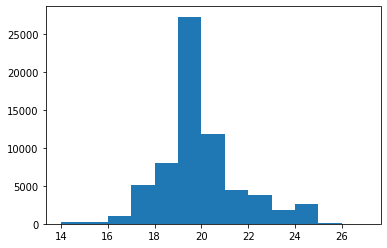

In [10]:
import matplotlib.pyplot as plt
plt.hist(df['length'],bins=max(df['length'])-min(df['length']));

In [11]:
sum(df['length'] < 18 ) + sum(df['length'] > 24 ) 

6626

## convert the result of the blast to bed file

In [12]:
flanking_value = 200
df = df[['sseqid', 'sstart', 'send', 'sstrand','slen']]

def switch(row):
    if(row['sstart'] > row['send']):
        temp = row['sstart']
        row['sstart'] = row['send']
        row['send'] = temp
    return row
df = df.apply(lambda row: switch(row), axis=1)

def convert(inp):
    if(inp == "plus"):
        return "forward"
    if(inp == "minus"):
        return "reverse"
    raise Exception('Error, sstrand contains illegal word! only "plus" and "minus" are allowed')
df['strand'] = df['sstrand'].apply(lambda x: convert(x))

def convert2sign(inp):
    if(inp == "plus"):
        return "+"
    if(inp == "minus"):
        return "-"
    raise Exception('Error, sstrand contains illegal word! only "plus" and "minus" are allowed')
df['sign'] = df['sstrand'].apply(lambda x: convert2sign(x))
df['sstart'] = df['sstart'].apply(lambda x: max(x - flanking_value - 1, 0))
df['send'] = df.apply(lambda row: min(row['send'] + flanking_value , row['slen']),axis=1)
df['ones'] = df['send'].apply(lambda row:1)
df.head(5)

,sseqid,sstart,send,sstrand,slen,strand,sign,ones
132836,AMWY02059828.1,2832,3256,plus,4662,forward,+,1
300170,AMWY02004761.1,1853,2277,plus,3675,forward,+,1
320840,AMWY02033394.1,469,893,minus,1874,reverse,-,1
39433,AMWY02098706.1,0,407,minus,2315,reverse,-,1
39436,AMWY02003241.1,1997,2420,plus,4402,forward,+,1


In [13]:
df[['sseqid','sstart','send','strand','ones', 'sign']].to_csv('./Temp/extension_index.bed', 
        index=False, header=False, sep="\t")

# Extention


## !sudo apt-get install bedtools

In [14]:
!bedtools getfasta -fi ./input_genome.fna -fo ./Temp/extended.txt -s -bed ./Temp/extension_index.bed
!rm input_genome.fna.fai

index file ./input_genome.fna.fai not found, generating...


In [15]:
# todo: remove duplicated
df = fasta_to_df("./Temp/extended.txt")
df = df.drop_duplicates(subset=['tag'], keep='first')
df_to_fasta(df,"./Temp/extended.txt")
len(df['tag'].unique()) 

65798

# RNA 2d prediction

## Mfold

In [132]:
'''
# installation
!wget http://www.unafold.org/download/mfold-3.6.tar.gz
!tar -xvf ./mfold-3.6.tar.gz; rm ./mfold-3.6.tar.gz
%cd ./mfold-3.6
!./configure
!make
!make install
%cd ..
!sudo apt install texlive-font-utils
''';

In [16]:
#todo : add all hyperparameter(options) to GUI

In [172]:
counter = 0
base = "./RNA_secondary_structure/mfold/"
!rm -r {base}
!mkdir -p {base}
df = fasta_to_df('./Temp/extended.txt')

for index, row in df.iterrows():    
    tag = reformat(row['tag'])
    if(not os.path.exists(base + tag)):
        os.makedirs(base + tag)            
    with open(base + f"{tag}/{tag}.FASTA",'w') as file:
        file.write(f">{row['tag']}\n{row['data']}")
    counter += 1    
    if(counter >= 1):
        break

In [173]:
def run_mfold(tag):
    tag = reformat(tag)
    %cd {base + tag}
    !mfold  SEQ="{tag}.FASTA" T=20 
    #!find . -type f ! -name "*.ct" ! -name "*.pdf" -exec rm {} \;
    %cd ../../..

if __name__ == '__main__':        
    pool = mp.Pool(mp.cpu_count() - 1)  
    pool.map(run_mfold, df['tag'].iloc[:1])

/home/jupyter/plant_microRNA_prediction/RNA_secondary_structure/mfold/AMWY020598281:2832-3256_+_
mfold version 3.6
REUSE= NO
AMWY020598281:2832-3256_+_.pnt created.
Sequence length is 424
RNA free energy files (version 2.3) at 20 degrees created.
10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420, 
End of Fill
Save file created using nafold.
Minimum folding energy is -127.70 kcal/mol.
Energy increment is 6.38 kcal/mol.
H-num file created from plot file.
1,2,3,4,5, 
Suboptimal foldings created.
Energy dot plot created.
+	+	+	+	+	
Structure plots generated.
All done.
/home/jupyter/plant_microRNA_prediction


## mxfold2

In [20]:
#!wget https://github.com/keio-bioinformatics/mxfold2/releases/download/v0.1.1/mxfold2-0.1.1.tar.gz
#!pip3 install mxfold2-0.1.1.tar.gz
#!rm mxfold2-0.1.1.tar.gz

In [142]:
!mxfold2 predict SEQ.FASTA > RNA_secondary_structure/mxfold2_result.txt

In [143]:
df = fasta_to_df('RNA_secondary_structure/mxfold2_result.txt')
df = df.apply(lambda row: bracket_row(row) , axis=1)
df.head(2)

,tag,data,bracket
0,AMWY02059828.1:2832-3256(+),AAAGAATCAGCAATGGAAAAATAACCGGTTCTTAATTCAGcataac...,........................((((...........((........
1,AMWY02004761.1:1853-2277(+),actaataatgCATGGCCATATATATCAAATCTACCATATgccattt...,.................................................


In [145]:
base = "./RNA_secondary_structure/mxfold2/"
!rm -r {base}
!mkdir -p {base}
for index, row in df.iterrows():    
    if(not os.path.exists(base + reformat(row['tag']))):
        os.makedirs(base + reformat(row['tag']))        
    tag = reformat(row['tag'])
    with open(base + f"{tag}/{tag}.ct",'w') as file:
        bracket = row['bracket'].split(' ')[0]
        deltaG = row['bracket'].split(' ')[1]
        ct = bracket_to_ct(row['tag'], row['data'], bracket, deltaG)
        file.write(ct)    

## SPOT-RNA

## Vienna package

In [271]:
#!wget https://www.tbi.univie.ac.at/RNA/download/ubuntu/ubuntu_20_04/viennarna_2.4.18-1_amd64.deb -O viennarna.deb
#!sudo dpkg -i ./viennarna.deb
#!sudo apt-get -f install
#!rm viennarna.deb

In [272]:
base = "./RNA_secondary_structure/viennarna/"
!rm -r {base}
!mkdir -p {base}

In [273]:
%cd {base}
!RNAfold --jobs=0 --infile ../../extended.txt  > ../viennarna_result.txt
%cd ../../

/home/jupyter/plant_microRNA_prediction/RNA_secondary_structure/viennarna
/home/jupyter/plant_microRNA_prediction


In [274]:
df = fasta_to_df('RNA_secondary_structure/viennarna_result.txt')
df = df.apply(lambda row: bracket_row(row) , axis=1)
df.head(2)

,tag,data,bracket
0,AMWY02059828.1:2832-3256(+),AAAGAAUCAGCAAUGGAAAAAUAACCGGUUCUUAAUUCAGcauaac...,........((.(((((.......((((((((((....(((((((.....
1,AMWY02004761.1:1853-2277(+),acuaauaaugCAUGGCCAUAUAUAUCAAAUCUACCAUAUgccauuu...,...........(((((.((((..............))))))))).....


In [275]:
for index, row in df.iterrows():    
    tag = reformat(row['tag'])
    if(not os.path.exists(base + tag)):
        os.makedirs(base + tag)      
    with open(base + f"{tag}/{tag}.ct",'w') as file:
        bracket = row['bracket'].split(' ')[0]
        deltaG = row['bracket'].split(' ')[1]
        ct = bracket_to_ct(row['tag'], row['data'], bracket, deltaG, False)
        file.write(ct)    

In [276]:
import glob
for file in glob.glob(f"{base}*.ps"):    
    f = file[len(base):-6] # _ss.ps 
    f = reformat(f)        
    shutil.move(file, f"{base}{f}/{f}.ps")    

./RNA_secondary_structure/viennarna/AMWY02067918.1_868-1289(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020679181_868-1289_-_/AMWY020679181_868-1289_-_.ps
./RNA_secondary_structure/viennarna/AMWY02033394.1_518-938(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020333941_518-938_-_/AMWY020333941_518-938_-_.ps
./RNA_secondary_structure/viennarna/AMWY02125553.1_3-321(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY021255531_3-321_-_/AMWY021255531_3-321_-_.ps
./RNA_secondary_structure/viennarna/AMWY02039981.1_1215-1636(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020399811_1215-1636_-_/AMWY020399811_1215-1636_-_.ps
./RNA_secondary_structure/viennarna/AMWY02044036.1_729-1150(+)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020440361_729-1150_+_/AMWY020440361_729-1150_+_.ps
./RNA_secondary_structure/viennarna/AMWY02083568.1_5790-6210(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020835681_5790-6210_-_/AMWY020835681_5790-6210_-_.ps
./RNA_secondary_structure/viennarna/AMWY020755

./RNA_secondary_structure/viennarna/AMWY02086587.1_1550-1971(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020865871_1550-1971_-_/AMWY020865871_1550-1971_-_.ps
./RNA_secondary_structure/viennarna/AMWY02013752.1_227-647(+)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020137521_227-647_+_/AMWY020137521_227-647_+_.ps
./RNA_secondary_structure/viennarna/AMWY02084282.1_178-599(+)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020842821_178-599_+_/AMWY020842821_178-599_+_.ps
./RNA_secondary_structure/viennarna/AMWY02022711.1_454-874(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020227111_454-874_-_/AMWY020227111_454-874_-_.ps
./RNA_secondary_structure/viennarna/AMWY02002487.1_2518-2938(+)_ss.ps
./RNA_secondary_structure/viennarna/AMWY020024871_2518-2938_+_/AMWY020024871_2518-2938_+_.ps
./RNA_secondary_structure/viennarna/AMWY02125728.1_173-484(-)_ss.ps
./RNA_secondary_structure/viennarna/AMWY021257281_173-484_-_/AMWY021257281_173-484_-_.ps
./RNA_secondary_structure/viennarna/AMWY020501

# CT Analizer

# BLASTX or DIMOND

# DIAMOND

https://github.com/bbuchfink/diamond

In [ ]:
'''
import hashlib
import os
parallel = [os.path.join(dp, f) for dp, dn, filenames in os.walk("./PRNA_secondary_structure") for f in filenames ]
series = [os.path.join(dp, f) for dp, dn, filenames in os.walk("./SRNA_secondary_structure") for f in filenames ]
for i in range(len(parallel)):        
    md5_hash = hashlib.md5()
    with open(parallel[i],"rb") as file:        
        md5_hash.update(file.read())
        digest1 = md5_hash.hexdigest()                
    md5_hash = hashlib.md5()
    with open(series[i],"rb") as file:        
        md5_hash.update(file.read())
        digest2 = md5_hash.hexdigest()                
    if(digest1 != digest2):
        print(parallel[i])
        print(series[i])
        print("***********")     
'''